In [3]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Bi-IV/cnews文本分类")

Mounted at /content/drive


# Action1_cnews 中文文本分类

使用1000训练集

由清华大学根据新浪新闻RSS订阅频道2005-2011年间的历史数据筛选过滤生成     训练集 50000     验证集 5000     测试集 10000     词汇（字） 5000     10个分类，包括：'体育', '财经', '房产', '家居', '教育', '科技', '时尚', '时政', '游戏', '娱乐'

In [4]:
# 设置数据目录
train_file = 'cnews.train.small.txt'
test_file = 'cnews.test.txt'
val_file = 'cnews.val.txt'
vocab_file = 'cnews.vocab.txt'

In [5]:
import torch
from torch import nn
from model import TextRNN
from cnews_loader import read_vocab,read_category,process_file
from torch import optim

In [6]:
# 获取文本的类别及其对应id的字典
categories, cat_to_id = read_category()
print(categories)
# 获取训练文本中所有出现过的字及其所对应的id
words, word_to_id = read_vocab('cnews.vocab.txt')
print(words)
# 获取训练数据每个字的id和对应标签的one-hot形式
x_train, y_train = process_file(train_file, word_to_id, cat_to_id, 600)
print('x_train=', x_train)
x_val, y_val = process_file(val_file, word_to_id, cat_to_id, 600)


['体育', '财经', '房产', '家居', '教育', '科技', '时尚', '时政', '游戏', '娱乐']
['<PAD>', '，', '的', '。', '一', '是', '在', '0', '有', '不', '了', '中', '1', '人', '大', '、', '国', '', '2', '这', '上', '为', '个', '“', '”', '年', '学', '时', '我', '地', '和', '以', '到', '出', '来', '会', '行', '发', '：', '对', '们', '要', '生', '家', '他', '能', '也', '业', '金', '3', '成', '可', '分', '多', '现', '5', '就', '场', '新', '后', '于', '下', '日', '经', '市', '前', '过', '方', '得', '作', '月', '最', '开', '房', '》', '《', '高', '9', '8', '.', '而', '比', '公', '4', '说', ')', '将', '(', '都', '资', 'e', '6', '基', '用', '面', '产', '还', '自', '者', '本', '之', '美', '很', '同', '', '7', '部', '进', '但', '主', '外', '动', '机', '元', '理', '加', 'a', '全', '与', '实', '影', '好', '小', '间', '其', '天', '定', '表', '力', '如', '次', '合', '长', 'o', '体', '价', 'i', '所', '内', '子', '目', '电', '-', '当', '度', '品', '看', '期', '关', '更', 'n', '等', '工', '然', '斯', '重', '些', '球', '此', '里', '利', '相', '情', '投', '点', '没', '因', '已', '三', '心', '特', '明', '位', '两', '法', '从', '入', '名', '万', '手', '计', '性', '事', '只', '样', '示', 'r', '

In [7]:
loss_list = []
loss_epoch_list = []
accuracy_epoch_list = []
accuracy_mean_list = []   # 每个epoch计算一次accuracy平均
loss_epochMean_list = []   # 每个epoch计算一次loss平均
def train():
    model = TextRNN().cuda()
    # 定义损失函数
    Loss = nn.MultiLabelSoftMarginLoss() # 多类别（multi-class）多分类（multi-classification）的 Hinge 损失
    optimizer = optim.Adam(model.parameters(),lr=0.001)
    
    best_val_acc = 0
    
    for epoch in range(1000):
        print('epoch=',epoch)
        # 分批训练
        temp_loss = 0
        accuracy_mean = 0
        for step, (x_batch, y_batch) in enumerate(train_loader):
            
            x = x_batch.cuda()  #[128, 600]
            y = y_batch.cuda() # [128, 10]
            # 前向传播
            out = model(x) # [128, 10]
            loss = Loss(out, y)
            loss_list.append(loss) # 保存loss，方便画图
            temp_loss += loss
            print('loss=', loss)
            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            accuracy = np.mean((torch.argmax(out,1) == torch.argmax(y,1)).cpu().numpy())
            accuracy_mean += accuracy
            print('accuracy=', accuracy)
        # print(step,temp_loss)
        accuracy_epoch_list.append(accuracy)
        accuracy_mean_list.append(accuracy_mean/(step+1))
        loss_epoch_list.append(loss) # 保存loss，方便画图
        loss_epochMean_list.append(temp_loss/(step+1))

        if (epoch+1)%5==0:
            # 模型验证
            for step, (x_batch, y_batch) in enumerate(val_loader):
                x = x_batch.cuda()
                y = y_batch.cuda()
                # 前向传播
                out = model(x)
                accuracy = np.mean((torch.argmax(out,1) == torch.argmax(y,1)).cpu().numpy())
                if accuracy > best_val_acc:
                    torch.save(model,'model.pkl')
                    best_val_acc = accuracy
                    print('model.pkl saved')
                    print('accuracy=',accuracy)
                    

In [8]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
import torch.utils.data as Data
import numpy as np
# 设置GPU
cuda = torch.device('cuda')
x_train, y_train = torch.LongTensor(x_train), torch.Tensor(y_train).to(dtype=torch.int64)
x_val, y_val = torch.LongTensor(x_val), torch.Tensor(y_val).to(dtype=torch.int64)

# .TensorDataset检查x_train和y_train第一维是否相同，相同则继续
# (1000,600)(1000,10)，assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
train_dataset = Data.TensorDataset(x_train, y_train)  
val_dataset = Data.TensorDataset(x_val, y_val)
#
train_loader = Data.DataLoader(dataset = train_dataset, batch_size=128, shuffle=True)
val_loader = Data.DataLoader(dataset = val_dataset, batch_size=128)

In [10]:
train()

epoch= 0
loss= tensor(0.7344, device='cuda:0', grad_fn=<MeanBackward0>)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


流式输出内容被截断，只能显示最后 5000 行内容。
accuracy= 0.4807692307692308
epoch= 706
loss= tensor(0.7043, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.46875
loss= tensor(0.7096, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.4140625
loss= tensor(0.7058, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.4375
loss= tensor(0.7048, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.4765625
loss= tensor(0.7066, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.484375
loss= tensor(0.7073, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.421875
loss= tensor(0.7120, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.3984375
loss= tensor(0.7070, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.40384615384615385
epoch= 707
loss= tensor(0.7098, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.4375
loss= tensor(0.7070, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.4609375
loss= tensor(0.7084, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.3984375
loss= ten

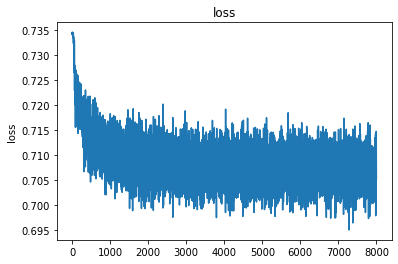

In [11]:
# loader每个批的每8个loss(1000//128)
import matplotlib.pyplot as plt
plt.plot(range(1,len(loss_list)+1),loss_list)
plt.title('loss')
plt.ylabel('loss')
plt.show()

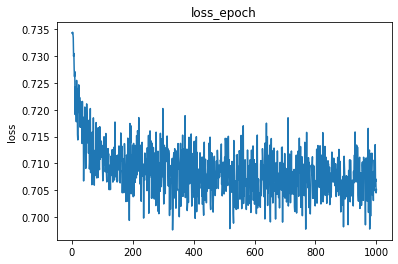

In [12]:
# 每个loader批的最后一个loss
plt.plot(range(1,len(loss_epoch_list)+1),loss_epoch_list)
plt.title('loss_epoch')
plt.ylabel('loss')
plt.show()

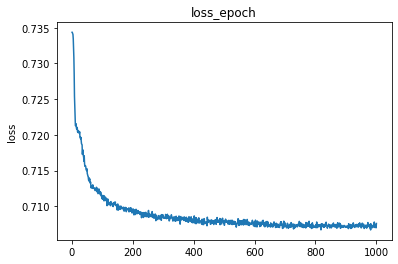

In [13]:
# 每个epoch的平均loss
plt.plot(range(1,len(loss_epochMean_list)+1),loss_epochMean_list)
plt.title('loss_epoch')
plt.ylabel('loss')
plt.show()

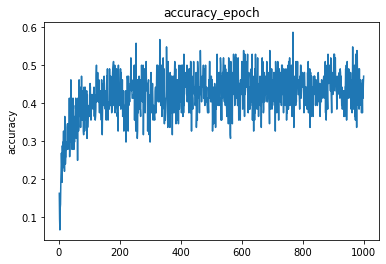

In [14]:
# 每个loader批的最后一个accuracy
plt.plot(range(1,len(accuracy_epoch_list)+1),accuracy_epoch_list)
plt.title('accuracy_epoch')
plt.ylabel('accuracy')
plt.show()

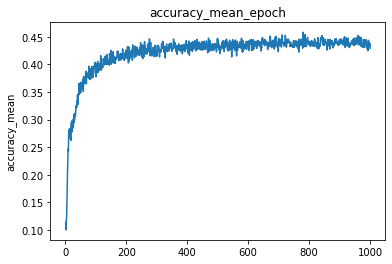

In [15]:
# 每个epoch的平均accuracy
plt.plot(range(1,len(accuracy_mean_list)+1),accuracy_mean_list)
plt.title('accuracy_mean_epoch')
plt.ylabel('accuracy_mean')
plt.show()

## cnews_loader.py模块

In [14]:
import numpy as np
import tensorflow.keras as kr

# 读取词汇表
def read_vocab(vocab_dir):
    with open(vocab_dir, 'r', encoding='utf-8', errors='ignore') as fp:
        words = [_.strip() for _ in fp.readlines()] #所有字及符号words[:15] ['<PAD>', '，', '的', '。', '一', '是', '在', '0', '有', '不', '了', '中', '1', '人', '大']
    word_to_id = dict(zip(words, range(len(words))))# 给所有字及符号从0开始编号'<PAD>': 0, '，': 1, '的': 2, '。': 3, '一': 4, '是': 5, '在': 6, '0': 7, '有': 8, '不': 9, '了': 10, '中': 11
    return words, word_to_id
 
 
# 读取分类目录，固定
def read_category():
    categories = ['体育', '财经', '房产', '家居', '教育', '科技', '时尚', '时政', '游戏', '娱乐']
    # categories = [x for x in categories]
    cat_to_id = dict(zip(categories, range(len(categories)))) 
    return categories, cat_to_id
 
 
# 将文件转换为id表示
def process_file(filename, word_to_id, cat_to_id, max_length=600):
    contents, labels = [], []
    with open(filename, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            try:
                label, content = line.strip().split('\t')
                if content:
                    contents.append(list(content)) # [['马', '晓', '旭', '意', '外', '受', '伤'
                    labels.append(label) # ['体育', '体育', '体育', '体育', '体育',
            except:
                pass
    data_id, label_id = [], []
    for i in range(len(contents)):
        data_id.append([word_to_id[x] for x in contents[i] if x in word_to_id])#将每句话id化
        label_id.append(cat_to_id[labels[i]])#每句话对应的类别的id
    #
    # # 使用keras提供的pad_sequences来将文本pad为固定长度
    x_pad = kr.preprocessing.sequence.pad_sequences(data_id, max_length) #(1000,600)
    y_pad = kr.utils.to_categorical(label_id, num_classes=len(cat_to_id))  # 将标签转换为one-hot表示(1000,10)
    #
    return x_pad, y_pad

## model模块

In [15]:
# TextRNN Model

import torch
from torch import nn
import torch.nn.functional as F
 
# 文本分类，RNN模型
class TextRNN(nn.Module):   
    def __init__(self):
        super(TextRNN, self).__init__()
        # 三个待输入的数据
        self.embedding = nn.Embedding(5000, 64)  #  进行词嵌入
        # self.rnn = nn.LSTM(input_size=64, hidden_size=128, num_layers=2, bidirectional=True)
        self.rnn = nn.GRU(input_size=64, hidden_size=128, num_layers=2, bidirectional=True)
        self.f1 = nn.Sequential(nn.Linear(256,128),
                                nn.Dropout(0.8),
                                nn.ReLU())
        self.f2 = nn.Sequential(nn.Linear(128,10),
                                nn.Softmax())
 
    def forward(self, x):
        x = self.embedding(x)
        x,_ = self.rnn(x)
        x = F.dropout(x,p=0.8)
        x = self.f1(x[:,-1,:])
        return self.f2(x)